# 6.4 Supervised Machine Learning: Regression

### This script includes the following:
1. Importing libraries and data
2. Data cleaning
3. Data prep for regression analysis
4. Regression analysis
5. Bonus: Performance improvement after removing outliers

### 1. Importing libraries and data

In [5605]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.express as px
import matplotlib
from geopy.distance import geodesic
import sklearn
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures  # Add this line
from sklearn.metrics import mean_squared_error, r2_score

In [5606]:
# This command propts matplotlib visuals to appear in the notebook 
%matplotlib inline

In [5607]:
path = r'/Users/rose/Documents/My Tableau Repository/Advance Analytics & Dashboard Design'

In [5608]:
df_listings_visualized = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'listings_visualized.pkl'))

### 2. Data Cleaning 

In [5609]:
df_listings_visualized.head(2)

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,ward,latitude,longitude,room_type,accommodates,beds,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,price_usd,region,pricing_score,rating_score
0,197677,964081,within a day,100.0,1,1,Sumida Ku,35.71707,139.82608,Entire home/apt,2,2.0,3,174,4.77,0,74.0,Eastern,Low Price,High Rating
1,776070,801494,within an hour,100.0,1,1,Kita Ku,35.73844,139.76917,Private room,1,1.0,3,249,4.98,0,53.0,Northern,Low Price,High Rating


In [5610]:
df_listings_visualized.shape

(12197, 20)

#### Missing value checks

In [5611]:
df_listings_visualized.isnull().sum()

id                        0
host_id                   0
host_response_time        0
host_response_rate        0
host_is_superhost         0
host_identity_verified    0
ward                      0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
beds                      0
minimum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
price_usd                 0
region                    0
pricing_score             0
rating_score              0
dtype: int64

#### Duplicates check

In [5612]:
dups_listings = df_listings_visualized.duplicated()
dups_listings.shape

(12197,)

In [5613]:
df_listings_visualized.describe().round(2)

,host_response_rate,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,beds,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,price_usd
count,12197.00,12197.00,12197.00,12197.00,12197.00,12197.00,12197.00,12197.00,12197.00,12197.00,12197.00,12197.00
mean,99.23,0.32,0.98,35.70,139.74,4.00,2.41,1.98,37.01,4.68,0.75,146.10
std,4.63,0.47,0.15,0.04,0.06,2.59,1.68,2.89,61.83,0.33,0.43,85.13
min,0.00,0.00,0.00,35.54,139.58,1.00,1.00,1.00,0.00,1.00,0.00,10.00
25%,100.00,0.00,1.00,35.69,139.70,2.00,1.00,1.00,4.00,4.60,0.00,83.00
50%,100.00,0.00,1.00,35.70,139.73,3.00,2.00,1.00,15.00,4.71,1.00,127.00
75%,100.00,1.00,1.00,35.72,139.79,5.00,3.00,2.00,46.00,4.88,1.00,191.00
max,100.00,1.00,1.00,35.81,139.91,16.00,20.00,29.00,2258.00,5.00,1.00,410.00


In [5614]:
type(df_listings_visualized)

pandas.core.frame.DataFrame

In [5615]:
df_listings_visualized.shape

(12197, 20)

In [5616]:
df_listings_visualized['minimum_nights'].value_counts(dropna = False)

minimum_nights
1     6411
2     4119
3      991
4      255
5      186
29      64
7       51
28      42
20      21
14      18
6       15
21       8
10       7
25       3
16       3
15       3
Name: count, dtype: int64

#### Deriving additional column for regression: Shinjuku Station

In [5617]:
def calculate_distances(df_listings_visualized, points_of_interest):
    # Extract latitude and longitude from the dataframe
    coords = df_listings_visualized[['latitude', 'longitude']].values

    # Create an array of coordinates for points of interest
    poi_names = []
    poi_coords = []
    for name, coord in points_of_interest.items():
        if isinstance(coord, (list, tuple)) and len(coord) == 2:
            poi_names.append(name)
            poi_coords.append(coord)
    
    poi_coords = np.array(poi_coords)

    # Calculate distances using cdist
    distances = cdist(coords, poi_coords, metric='euclidean')

    # Convert to kilometers (approximate, assuming a spherical Earth)
    earth_radius = 6371  # km
    distances_km = distances * (np.pi / 180) * earth_radius

    # Create new columns in the dataframe
    for i, poi_name in enumerate(poi_names):
        df_listings_visualized[f'distance_to_{poi_name}'] = distances_km[:, i]

    return df_listings_visualized

# Points of interest coordinates
points_of_interest = {
    'Shinjuku Station': (35.6896, 139.7006),
    'Tokyo Tower': (35.6586, 139.7454),
    'Tsukiji Outer Market': (35.665091, 139.770691),
    'Akihabara': (35.698333, 139.773056),
    'Koishikawa Korakuen': (35.705556, 139.749167),
    'Hama Rikyu': (35.660000, 139.761944),
    'Imperial Palace': (35.682500, 139.752100),
    'Imperial East Gardens': (35.686800, 139.757100),
    'Ginza': (35.671111, 139.765000),
    'Nihonbashi': (35.683889, 139.774444),
    'Yasukuni Shrine': (35.693889, 139.742778),
    'Tokyo Dome City': (35.705400, 139.752100),
    'Tsukishima': (35.663600, 139.781800),
    'Yurakucho': (35.674600, 139.762000),
    'Marunouchi': (35.6762, 139.7614),
    'Kanda': (35.7023, 139.7712),
    'State Guest House': (35.695, 139.7498),
    'Tokyo National Museum': (35.7199, 139.77),
    'Tokyo Skytree': (35.7101, 139.8107),
    'Asakusa': (35.711, 139.7967),
    'Sensoji Temple': (35.7147, 139.7967),
    'Edo-Tokyo Museum': (35.6962, 139.7976),
    'Rikugien': (35.7352, 139.7336),
    'Ueno Park': (35.7146, 139.774),
    'Tokyo Solamachi': (35.7105, 139.8126),
    'Botanical Garden': (35.7103, 139.7493),
    'Yanaka': (35.7263, 139.7687),
    'Sumida Aquarium': (35.7106, 139.8114),
    'Ameyoko': (35.7093, 139.7749),
    'Ikebukuro': (35.7289, 139.7104),
    'Sumida Hokusai Museum': (35.7079, 139.8032),
    'Kappabashi Street': (35.7126, 139.7898),
    'Ryogoku': (35.6962, 139.7937),
    'Sugamo': (35.7325, 139.7396),
    'Shibuya': (35.664, 139.6982),
    'Shinjuku': (35.6895, 139.6917),
    'Meiji Shrine': (35.6764, 139.6994),
    'Harajuku': (35.6718, 139.7101),
    'Shinjuku Gyoen': (35.6852, 139.7103),
    'Yoyogi Park': (35.6712, 139.6955),
    'Tokyo Metropolitan Government Building': (35.6896, 139.6917),
    'Nakano Broadway': (35.7067, 139.6655),
    'Kagurazaka': (35.7021, 139.7347),
    'Yebisu Garden Place': (35.6438, 139.7159),
    'Daikanyama': (35.6484, 139.701),
    'Odaiba	35.619': (139.7798),
    'Institute for Nature Study': (35.6465, 139.6983),
    'Toyosu Market': (35.6551, 139.8164),
    'Roppongi Hills': (35.6605, 139.729),
    'Tokyo Tower': (35.6586, 139.7454),
    'Zojoji Temple': (35.6574, 139.7487),
    'Sengakuji Temple': (35.6299, 139.7405),
    'Tokyo Water Bus': (35.6562, 139.7738),
    'Kyu Shiba Rikyu': (35.6581, 139.7544),
    'Tokyo Midtown': (35.6653, 139.7302),
    'Roppongi': (35.6628, 139.7317),
    'Akasaka Sacas': (35.6751, 139.7367),
    'Shiodome': (35.6653, 139.7595),
    'Shinagawa': (35.6288, 139.7389),
    'Toyosu': (35.655, 139.8144),
}

# Apply function to dataframe
df_listings_visualized = calculate_distances(df_listings_visualized, points_of_interest)



In [5618]:
df_listings_visualized.head(2)

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,ward,latitude,longitude,room_type,...,distance_to_Zojoji Temple,distance_to_Sengakuji Temple,distance_to_Tokyo Water Bus,distance_to_Kyu Shiba Rikyu,distance_to_Tokyo Midtown,distance_to_Roppongi,distance_to_Akasaka Sacas,distance_to_Shiodome,distance_to_Shinagawa,distance_to_Toyosu
0,197677,964081,within a day,100.0,1,1,Sumida Ku,35.71707,139.82608,Entire home/apt,...,10.865385,13.583335,8.922210,10.321072,12.116221,12.105863,10.979769,9.378044,13.795318,7.023003
1,776070,801494,within an hour,100.0,1,1,Kita Ku,35.73844,139.76917,Private room,...,9.294261,12.483036,9.159151,9.083114,9.215182,9.386202,7.914593,8.203570,12.647514,10.553556


In [5619]:
df_listings_visualized.shape

(12197, 78)

In [5620]:
df_listings_visualized.columns

Index(['id', 'host_id', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_identity_verified', 'ward', 'latitude',
       'longitude', 'room_type', 'accommodates', 'beds', 'minimum_nights',
       'number_of_reviews', 'review_scores_rating', 'instant_bookable',
       'price_usd', 'region', 'pricing_score', 'rating_score',
       'distance_to_Shinjuku Station', 'distance_to_Tokyo Tower',
       'distance_to_Tsukiji Outer Market', 'distance_to_Akihabara',
       'distance_to_Koishikawa Korakuen', 'distance_to_Hama Rikyu',
       'distance_to_Imperial Palace', 'distance_to_Imperial East Gardens',
       'distance_to_Ginza', 'distance_to_Nihonbashi',
       'distance_to_Yasukuni Shrine', 'distance_to_Tokyo Dome City',
       'distance_to_Tsukishima', 'distance_to_Yurakucho',
       'distance_to_Marunouchi', 'distance_to_Kanda',
       'distance_to_State Guest House', 'distance_to_Tokyo National Museum',
       'distance_to_Tokyo Skytree', 'distance_to_Asakusa',


### 3.1 Data prep for regression analysis for price and major public trasportation station

In [5621]:
# Calculate distance given the coordinates of Shinjuku Station's coordinates
shinjuku_station_latitude = 35.696571
shinjuku_station_longitude = 139.705505

def calculate_distance(row):
    point = (row['latitude'], row['longitude'])
    subway_point = (shinjuku_station_latitude, shinjuku_station_longitude)
    return geodesic(point, subway_point).meters  # Distance in meters

# Create a new 'Distance_to_shinjuku_station' column 
df_listings_visualized['distance_to_shinjuku_station'] = df_listings_visualized.apply(calculate_distance, axis=1)


In [5622]:
# Reshape the variables into NumPy arrays and put them into separate objects.
X = df_listings_visualized['distance_to_shinjuku_station'].values.reshape(-1, 1)
y = df_listings_visualized['price_usd'].values.reshape(-1,1)

In [5623]:
X

array([[11146.10653545],
       [ 7400.42186921],
       [ 3144.05754036],
       ...,
       [ 1898.78896476],
       [  448.070436  ],
       [  303.09692607]])

In [5624]:
y

array([[ 74.],
       [ 53.],
       [172.],
       ...,
       [201.],
       [348.],
       [346.]])

In [5625]:
# Split data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### Regression Analysis

In [5626]:
# Create a regression object. Run and fit the regression.
regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.
regression.fit(X_train, y_train) # Fit the regression object onto the training set.

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


LinearRegression()

In [5627]:
# Predict: predict the values of y using X
y_predicted = regression.predict(X_test)

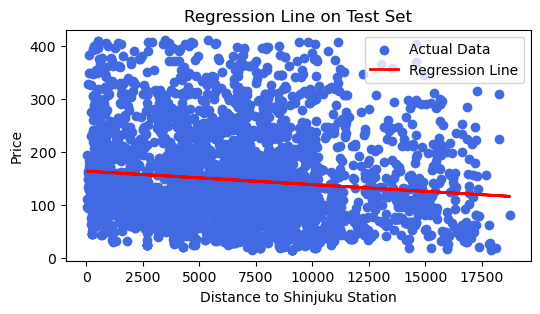

<Figure size 640x480 with 0 Axes>

In [5628]:
# Plot actual vs predicted values to visualize model performance
plt.figure(figsize=(6, 3))
plt.scatter(X_test, y_test, color='royalblue', label='Actual Data') 
plt.plot(X_test, y_predicted, color='red', linewidth=2, label='Regression Line')
plt.title('Regression Line on Test Set')
plt.xlabel('Distance to Shinjuku Station')
plt.ylabel('Price')
plt.legend()
plt.show()

# Export to the "Visualizations" folder
file_name = os.path.join(path, '04 Analysis', 'Visualization', 'regression_line_test_set_distance.png')
plt.savefig(file_name)

In [5629]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [5630]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[-0.00253514]]
Mean squared error:  7196.302958414858
R2 score:  0.015246461689740975


The slope suggests a weak negative relationship between the independent (distance) and dependent variable (price), as the independent variable increases, the dependent variable slightly decreases. MSE is high which means poor predictive performance--with the average squared difference between the observed actual outcomes and the outcomes predicted by the model quite large. The very low R2 score further suggests the model does not fit the data very well-- 0.0152 indicates that the model explains only about 1.52% of the variance in the dependent variable.

In [5631]:
y_predicted.round(2)

array([[137.42],
       [158.16],
       [147.28],
       ...,
       [133.33],
       [158.51],
       [157.92]])

In [5632]:
# Create a dataframe comparing the actual and predicted values of y.
data_comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data_comparison.head(10)

,Actual,Predicted
0,403.0,137.417477
1,126.0,158.164186
2,181.0,147.282434
3,360.0,152.158972
4,221.0,142.802040
5,91.0,156.247516
6,193.0,138.867555
7,91.0,144.749386
8,172.0,155.889072
9,221.0,119.316105


#### Compare how the regression fits the training set

In [5633]:
# Predict.
y_predicted_train = regression.predict(X_train) # This is predicting X_train!

In [5634]:
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [5635]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[-0.00253514]]
Mean squared error:  7116.230874490011
R2 score:  0.01429028172122504


For the training set, slope is exactly the same as the test set: negative indicating an inverse relationship between price and distance. Mean squared error remains large indicating large discrepancy between actual and predicted values. R2 remains low, which means poor predictive performance-- the model explains only about 1.58% of the variance in the dependent variable.

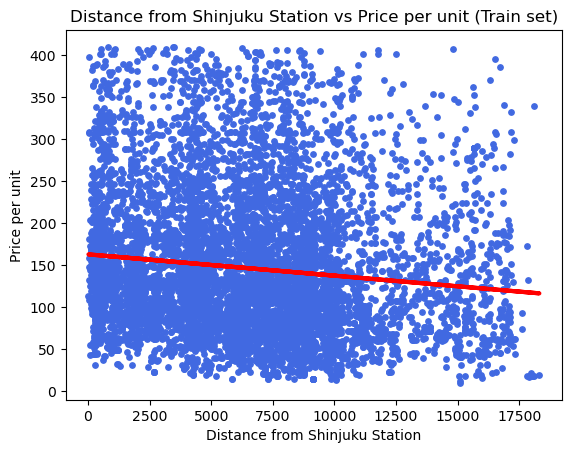

In [5636]:
# Visualizing the training set results.

plot_test = plt
plot_test.scatter(X_train, y_train, color='royalblue', s = 15)
plot_test.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_test.title('Distance from Shinjuku Station vs Price per unit (Train set)')
plot_test.xlabel('Distance from Shinjuku Station')
plot_test.ylabel('Price per unit')
plot_test.show()

Overall, distance is not predictive of price. Other variables may be in play.

### 3.2 Data prep for regression analysis for price and beds

In [5637]:
# Reshape the variables into NumPy arrays and put them into separate objects.
X = df_listings_visualized['beds'].values.reshape(-1, 1)
y = df_listings_visualized['price_usd'].values.reshape(-1,1)

In [5638]:
X

array([[2.],
       [1.],
       [4.],
       ...,
       [3.],
       [4.],
       [5.]])

In [5639]:
y

array([[ 74.],
       [ 53.],
       [172.],
       ...,
       [201.],
       [348.],
       [346.]])

In [5640]:
# Split data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [5641]:
# Split data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [5642]:
# Create a regression object.
regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [5643]:
# Fit the regression object onto the training set.
regression.fit(X_train, y_train)

LinearRegression()

In [5644]:
# Predict the values of y using X.
y_predict = regression.predict(X_test)

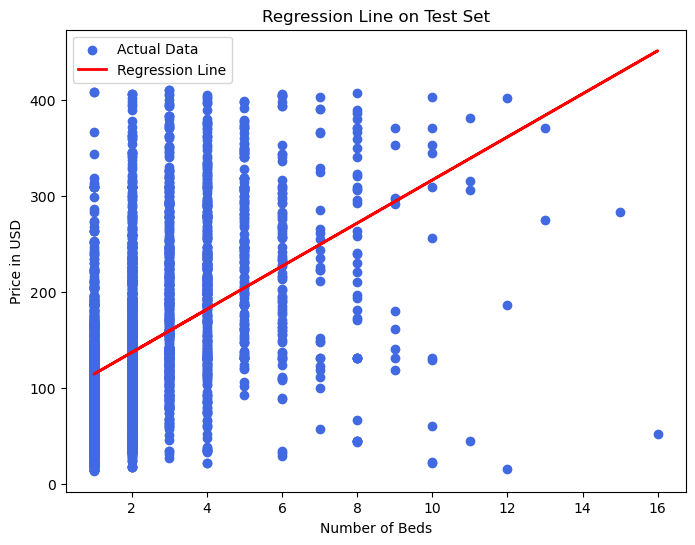

<Figure size 640x480 with 0 Axes>

In [5645]:
# Plot actual vs predicted values to visualize model performance
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='royalblue', label='Actual Data')
plt.plot(X_test, y_predict, color='red', linewidth=2, label='Regression Line')
plt.title('Regression Line on Test Set')
plt.xlabel('Number of Beds')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

# Export to the "Visualizations" folder
file_name = os.path.join(path, '04 Analysis', 'Visualization', 'regression_line_test_set_beds.png')
plt.savefig(file_name)

In [5646]:
# Create objects that contain the model summary statistics.
rmse = mean_squared_error(y_test, y_predict) # This is the mean squared error
r2 = r2_score(y_test, y_predict) # This is the R2 score. 

In [5647]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[22.41980705]]
Mean squared error:  5599.146307985733
R2 score:  0.2338039170712869


The slope is positive, suggesting a positive relationship. MSE is high which suggests poor predictive performance--with the average squared difference between the observed actual outcomes and the outcomes predicted by the model far apart. The R2 of 0.2338 indicates that the model explains about 23% of the variance in the dependent variable, but leaving 77% of the variabce unexplained by the model. Overall, a better predictor than distance.

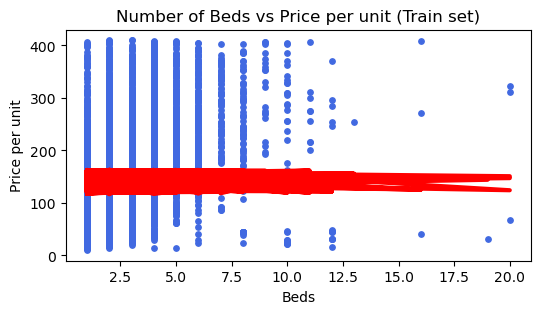

In [5648]:
# Visualizing the training set results.
plt.figure(figsize=(6, 3))
plot_test = plt
plot_test.scatter(X_train, y_train, color='royalblue', s = 15)
plot_test.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_test.title('Number of Beds vs Price per unit (Train set)')
plot_test.xlabel('Beds')
plot_test.ylabel('Price per unit')
plot_test.show()

### 3.3 Data prep for regression analysis for price and accommodates

In [5649]:
# Reshape the variables into NumPy arrays and put them into separate objects.
X = df_listings_visualized['accommodates'].values.reshape(-1, 1)
y = df_listings_visualized['price_usd'].values.reshape(-1,1)

In [5650]:
X

array([[2],
       [1],
       [6],
       ...,
       [5],
       [7],
       [7]])

In [5651]:
y

array([[ 74.],
       [ 53.],
       [172.],
       ...,
       [201.],
       [348.],
       [346.]])

In [5652]:
# Split data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### Regression analysis

In [5653]:
# Create a regression object. Run and fit the regression.
regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.
regression.fit(X_train, y_train) # Fit the regression object onto the training set.

LinearRegression()

In [5654]:
# Predict: predict the values of y using X
y_predicted = regression.predict(X_test)

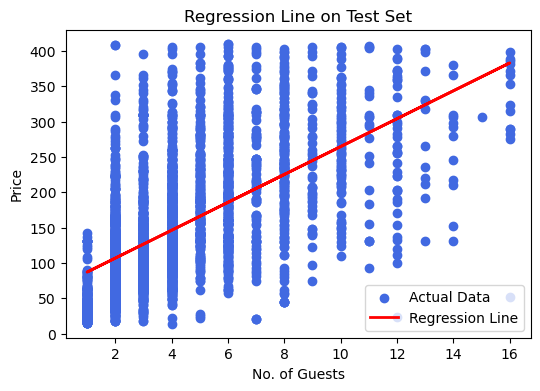

<Figure size 640x480 with 0 Axes>

In [5655]:
# Plot actual vs predicted values to visualize model performance
plt.figure(figsize=(6, 4))
plt.scatter(X_test, y_test, color='royalblue', label='Actual Data')
plt.plot(X_test, y_predicted, color='red', linewidth=2, label='Regression Line')
plt.title('Regression Line on Test Set')
plt.xlabel('No. of Guests')
plt.ylabel('Price')
plt.legend()
plt.show()

# Export to the "Visualizations" folder
file_name = os.path.join(path, '04 Analysis', 'Visualization', 'regression_line_test_set_distance.png')
plt.savefig(file_name)

In [5656]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [5657]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[19.72502714]]
Mean squared error:  4441.190960959179
R2 score:  0.39226036780426976


In [5658]:
y_predicted.round(2)

array([[225.08],
       [146.18],
       [106.73],
       ...,
       [ 87.01],
       [146.18],
       [185.63]])

In [5659]:
# Create a dataframe comparing the actual and predicted values of y.
data_comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data_comparison.head(10)

,Actual,Predicted
0,403.0,225.084924
1,126.0,146.184816
2,181.0,106.734761
3,360.0,185.634870
4,221.0,106.734761
5,91.0,106.734761
6,193.0,165.909843
7,91.0,106.734761
8,172.0,165.909843
9,221.0,225.084924


#### Compare how the regression fits the training set

In [5660]:
# Predict.
y_predicted_train = regression.predict(X_train) # This is predicting X_train!

In [5661]:
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [5662]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[19.72502714]]
Mean squared error:  4577.524845802807
R2 score:  0.36594093056406896


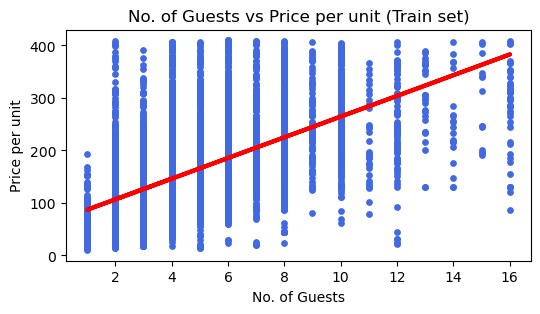

In [5663]:
# Visualizing the training set results.
plt.figure(figsize=(6, 3))
plot_test = plt
plot_test.scatter(X_train, y_train, color='royalblue', s = 15)
plot_test.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_test.title('No. of Guests vs Price per unit (Train set)')
plot_test.xlabel('No. of Guests')
plot_test.ylabel('Price per unit')
plot_test.show()

In [5664]:
df_listings_visualized.shape

(12197, 79)

#### Create a subset, df_low_price, for listings that are priced <=$200 and Test for neighborhood/ward

In [5665]:
# Filter based on highest price
df_low_price = df_listings_visualized[df_listings_visualized['price_usd'] <= 200]

<Figure size 600x300 with 0 Axes>

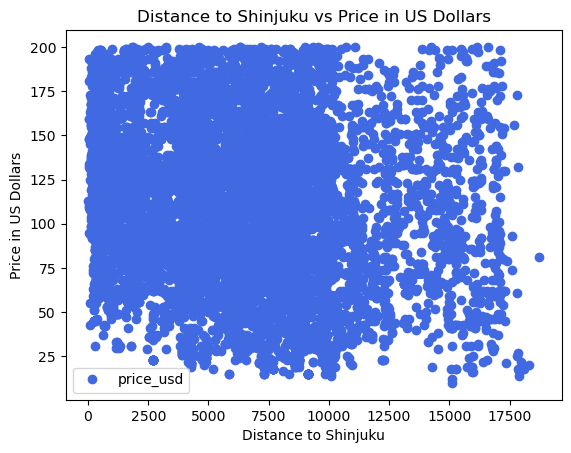

In [5666]:
# See how the scatterplot looks without outliers.
plt.figure(figsize=(6, 3))
df_low_price.plot(x = 'distance_to_shinjuku_station', y='price_usd', style='o', color='royalblue')  
plt.title('Distance to Shinjuku vs Price in US Dollars')  
plt.xlabel('Distance to Shinjuku')  
plt.ylabel('Price in US Dollars')  
plt.show()

In [5667]:
# Reshape again.
X_2 = df_low_price['distance_to_shinjuku_station'].values.reshape(-1,1)
y_2 = df_low_price['price_usd'].values.reshape(-1,1)

In [5668]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=0)

In [5669]:
# Run and fit the regression.
regression = LinearRegression()  
regression.fit(X_train_2, y_train_2)

LinearRegression()

In [5670]:
# Predict.
y_predicted_2 = regression.predict(X_test_2)

In [5671]:
rmse = mean_squared_error(y_test_2, y_predicted_2)
r2 = r2_score(y_test_2, y_predicted_2)

In [5672]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[-0.00188769]]
Mean squared error:  1955.0849008640246
R2 score:  0.029757035938635545


Removing the data frame' outliers slightly improved the scores, but overall, the model remains a poor fit. Slope is still negative, mean squared error is reduced, but remains large and the R2 score still is still siginificantly low: 0.0284 indicates that the model explains only about 2.8% of the variance in the dependent variable.

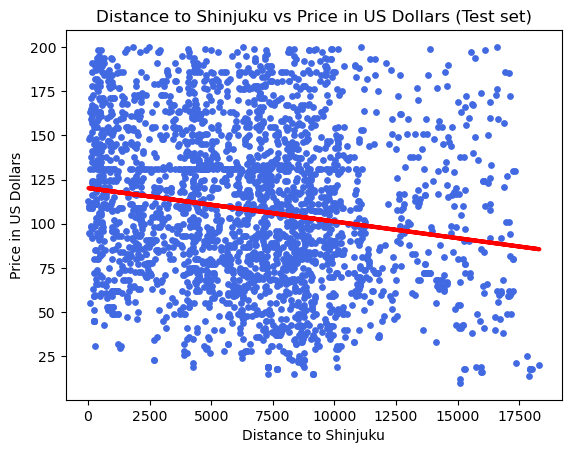

In [5673]:
# Visualizing the test set results.
plot_test = plt
plot_test.scatter(X_test_2, y_test_2, color='royalblue', s = 15)
plot_test.plot(X_test_2, y_predicted_2, color='red', linewidth =3)
plot_test.title('Distance to Shinjuku vs Price in US Dollars (Test set)')
plot_test.xlabel('Distance to Shinjuku')
plot_test.ylabel('Price in US Dollars')
plot_test.show()

In [5674]:
data = pd.DataFrame({'Actual': y_test_2.flatten(), 'Predicted': y_predicted_2.flatten()})
data.head(10)

,Actual,Predicted
0,109.0,101.975681
1,176.0,113.226760
2,106.0,119.198635
3,72.0,94.006040
4,137.0,112.135189
5,62.0,88.864001
6,83.0,105.610134
7,32.0,104.259517
8,87.0,109.535354
9,153.0,117.131121


#### Test for Shinjuku ward only: Test for other wards too by replacing value in desired_neighborhood

In [5675]:
# Specify the neighborhood you want to filter for
desired_neighborhood = 'Shinjuku Ku'

# Create a subset where only rows with the desired neighborhood are included
subset_df = df_low_price[df_low_price['ward'] == desired_neighborhood]

# Display the subsetted DataFrame 
subset_df.head(2)

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,ward,latitude,longitude,room_type,...,distance_to_Sengakuji Temple,distance_to_Tokyo Water Bus,distance_to_Kyu Shiba Rikyu,distance_to_Tokyo Midtown,distance_to_Roppongi,distance_to_Akasaka Sacas,distance_to_Shiodome,distance_to_Shinagawa,distance_to_Toyosu,distance_to_shinjuku_station
19,1526132,8142772,within an hour,100.0,1,1,Shinjuku Ku,35.69857,139.70400,Private room,...,8.647376,9.079430,7.187340,4.708856,5.030612,4.475690,7.195216,8.674532,13.197346,260.283044
22,1544970,8142772,within an hour,100.0,1,1,Shinjuku Ku,35.69848,139.70432,Private room,...,8.621881,9.043825,7.153344,4.679030,5.000962,4.440966,7.159559,8.649707,13.160575,237.415589


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of distance_to_shinjuku_station')

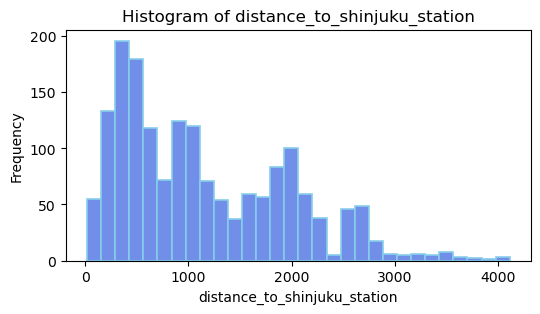

In [5676]:
# Set the size of the figure (width, height) in inches
plt.figure(figsize=(6, 3))  # Adjust width and height as needed

# Create a histogram with seaborn
sns.histplot(subset_df['distance_to_shinjuku_station'], bins=30, kde=False, color='royalblue', 
             edgecolor='skyblue', linewidth=1.2)

# Optionally, add labels and title
plt.xlabel('distance_to_shinjuku_station')
plt.ylabel('Frequency')
plt.title('Histogram of distance_to_shinjuku_station')

In [5677]:
subset_df['price_usd'].value_counts(dropna = False)

price_usd
131.0    92
111.0    43
109.0    43
62.0     32
124.0    31
         ..
43.0      2
35.0      1
29.0      1
48.0      1
34.0      1
Name: count, Length: 167, dtype: int64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of price_usd')

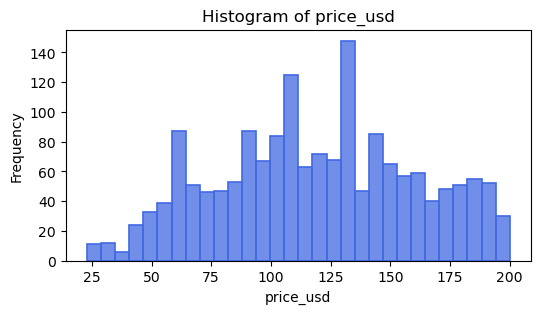

In [5678]:
# Set the size of the figure (width, height) in inches
plt.figure(figsize=(6, 3))  # Adjust width and height as needed

# Create a histogram with seaborn
sns.histplot(subset_df['price_usd'], bins=30, kde=False, color='royalblue', 
             edgecolor='royalblue', linewidth=1.2)

# Optionally, add labels and title
plt.xlabel('price_usd')
plt.ylabel('Frequency')
plt.title('Histogram of price_usd')

In [5679]:
# Define the independent variable (x) and the dependent variable (y)
X2 = subset_df['distance_to_shinjuku_station'].values.reshape(-1, 1)
y2 = subset_df['price_usd'].values

In [5680]:
X2

array([[ 260.28304351],
       [ 237.41558868],
       [ 236.01706415],
       ...,
       [1760.80773634],
       [1323.86575942],
       [ 823.80573751]])

In [5681]:
y2

array([ 59.,  59.,  45., ..., 194., 136., 152.])

In [5682]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=7)

In [5683]:
regression2 = LinearRegression()

In [5684]:
# Fit the regression object to the training data
regression2.fit(X2_train, y2_train)

LinearRegression()

In [5685]:
# Make predictions on X2_test
y2_pred = regression2.predict(X2_test)

# Calculate mean squared error and r2
mse = mean_squared_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)

# Print results
print('Slope (Coefficients): ', regression2.coef_)
print('Mean Squared Error:', mse)
print('R2 score:', r2)

Slope (Coefficients):  [-0.00713405]
Mean Squared Error: 1648.4871098199937
R2 score: 0.023175030517720074


Slope is still very low, mean squared error remains very high and R2 score again is low. Overall, these scores indicate that the linear regression model is not performing well, even as we isolated for the ward where Shinjuku station is located. 

In [5686]:
# Fit the regression object to the training data
regression.fit(X_train, y_train)

LinearRegression()

In [5687]:
# Predict on the test data
y_pred = regression.predict(X_test)

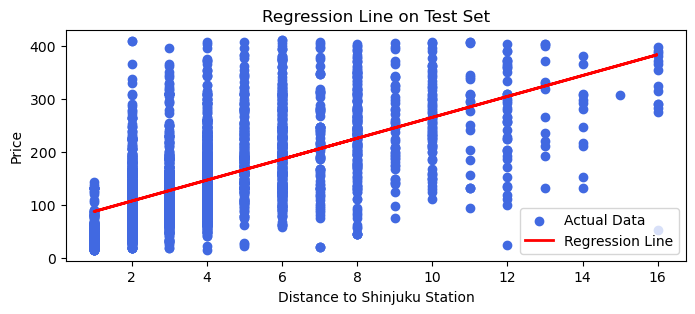

<Figure size 640x480 with 0 Axes>

In [5688]:
# Plot actual vs predicted values to visualize model performance
plt.figure(figsize=(8, 3))
plt.scatter(X_test, y_test, color='royalblue', label='Actual Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.title('Regression Line on Test Set')
plt.xlabel('Distance to Shinjuku Station')
plt.ylabel('Price')
plt.legend()
plt.show()

# Export to the "Visualizations" folder
file_name = os.path.join(path, '04 Analysis', 'Visualization', 'regression_line_test_set.png')
plt.savefig(file_name)

#### Try multiple regression on main dataframe: df_listings_visualized_filtered

In [5689]:
X = df_listings_visualized[['host_identity_verified', 'accommodates', 'review_scores_rating', 'distance_to_shinjuku_station']]
y = df_listings_visualized['price_usd']

for test

In [5690]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Multiple Linear Regression:")
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)



Multiple Linear Regression:
R2 Score: 0.3929232772675616
MSE: 4587.575941008243
Coefficients: [-1.62649787e+01  2.07444869e+01  1.70431319e+01 -3.71938500e-03]
Intercept: 23.153237946756548


for training

In [5691]:
# 2. Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

y_pred_poly = model_poly.predict(X_test_poly)

print("\nPolynomial Regression:")
print("R2 Score:", r2_score(y_test, y_pred_poly))
print("MSE:", mean_squared_error(y_test, y_pred_poly))



Polynomial Regression:
R2 Score: 0.4262778967003723
MSE: 4335.52073298985


Interaction between variables

In [5692]:
# 3. Interaction Terms
df_listings_visualized['host_accommodates'] = df_listings_visualized['host_identity_verified'] * df_listings_visualized['accommodates']
X_interact = df_listings_visualized[['distance_to_shinjuku_station', 'accommodates', 'review_scores_rating', 'host_accommodates']]

X_train_interact, X_test_interact, y_train, y_test = train_test_split(X_interact, y, test_size=0.2, random_state=42)

model_interact = LinearRegression()
model_interact.fit(X_train_interact, y_train)

y_pred_interact = model_interact.predict(X_test_interact)

print("\nInteraction Terms Regression:")
print("R2 Score:", r2_score(y_test, y_pred_interact))
print("MSE:", mean_squared_error(y_test, y_pred_interact))




Interaction Terms Regression:
R2 Score: 0.3933679426244311
MSE: 4584.215680242861


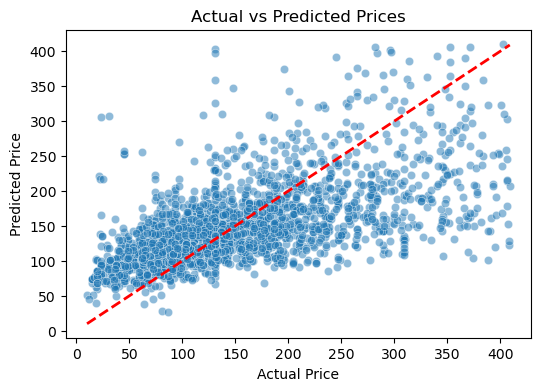

In [5693]:
# Visualizations
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()


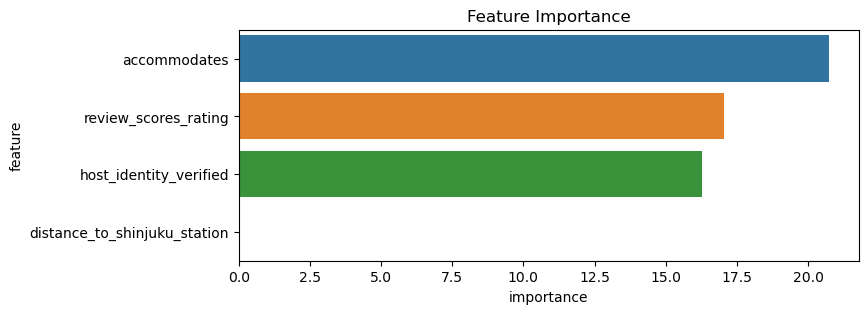

In [5694]:
# Feature Importance
importance = pd.DataFrame({'feature': X.columns, 'importance': abs(model.coef_)})
importance = importance.sort_values('importance', ascending=False)
plt.figure(figsize=(8, 3))
sns.barplot(x='importance', y='feature', data=importance)
plt.title("Feature Importance")
plt.show()

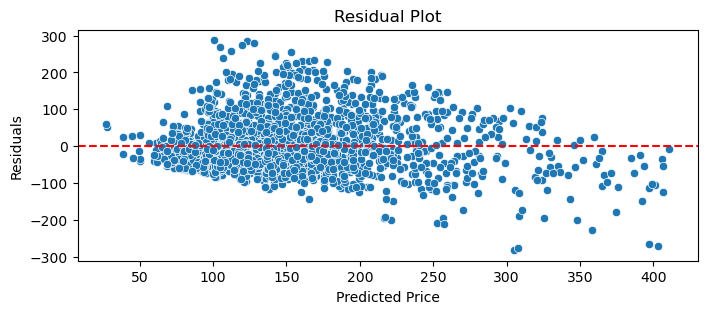

In [5695]:
# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 3))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

#### Multiple regression's results are better than linear regression

#### Try multiple regression on low price listings dataframe: df_low_price

In [5696]:
X = df_low_price[['host_identity_verified', 'accommodates', 'review_scores_rating', 'distance_to_shinjuku_station']]
y = df_low_price['price_usd']

In [5697]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Multiple Linear Regression:")
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)



Multiple Linear Regression:
R2 Score: 0.22936059035278933
MSE: 1544.751693981925
Coefficients: [-1.06789705e+01  1.11351986e+01  8.38866158e+00 -2.51159213e-03]
Intercept: 59.59797174231137


In [5698]:
# 2. Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

y_pred_poly = model_poly.predict(X_test_poly)

print("\nPolynomial Regression:")
print("R2 Score:", r2_score(y_test, y_pred_poly))
print("MSE:", mean_squared_error(y_test, y_pred_poly))




Polynomial Regression:
R2 Score: 0.30326506753842164
MSE: 1396.6096902170034


In [5699]:
# 3. Interaction Terms
df_low_price['host_accommodates'] = df_low_price['host_identity_verified'] * df_low_price['accommodates']
X_interact = df_low_price[['distance_to_shinjuku_station', 'accommodates', 'review_scores_rating', 'host_accommodates']]

X_train_interact, X_test_interact, y_train, y_test = train_test_split(X_interact, y, test_size=0.2, random_state=42)

model_interact = LinearRegression()
model_interact.fit(X_train_interact, y_train)

y_pred_interact = model_interact.predict(X_test_interact)

print("\nInteraction Terms Regression:")
print("R2 Score:", r2_score(y_test, y_pred_interact))
print("MSE:", mean_squared_error(y_test, y_pred_interact))




Interaction Terms Regression:
R2 Score: 0.2277088293626789
MSE: 1548.06265959773


/var/folders/3d/n4rd9d4920lcv99lmvhn9ghr0000gp/T/ipykernel_47607/846068945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low_price['host_accommodates'] = df_low_price['host_identity_verified'] * df_low_price['accommodates']


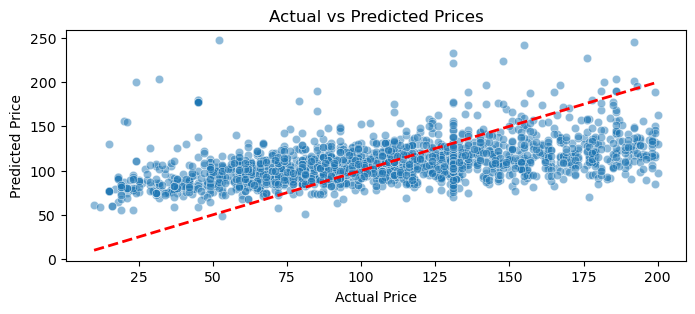

In [5700]:
# Visualizations
plt.figure(figsize=(8, 3))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()



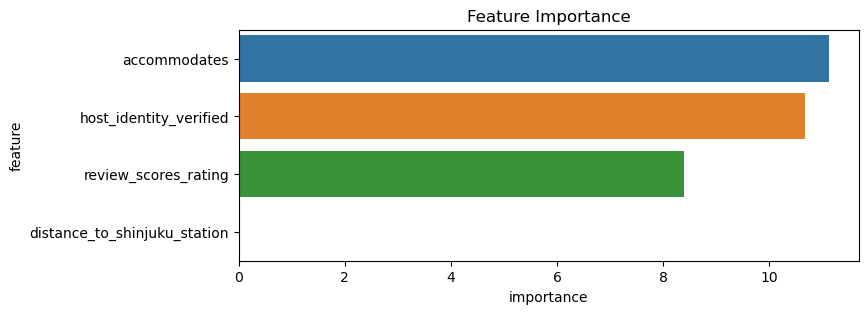

In [5701]:
# Feature Importance
importance = pd.DataFrame({'feature': X.columns, 'importance': abs(model.coef_)})
importance = importance.sort_values('importance', ascending=False)
plt.figure(figsize=(8, 3))
sns.barplot(x='importance', y='feature', data=importance)
plt.title("Feature Importance")
plt.show()

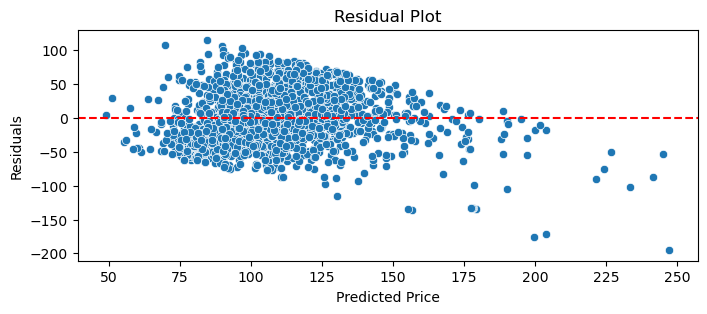

In [5702]:
# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 3))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

#### Test for neighborhood/ward

In [5703]:
# Specify the neighborhood you want to filter for
desired_neighborhood = 'Shinjuku Ku'

# Create a subset where only rows with the desired neighborhood are included
subset_df_ward = df_listings_visualized[df_listings_visualized['ward'] == desired_neighborhood]

# Display the subsetted DataFrame 
subset_df_ward.head()

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,ward,latitude,longitude,room_type,...,distance_to_Tokyo Water Bus,distance_to_Kyu Shiba Rikyu,distance_to_Tokyo Midtown,distance_to_Roppongi,distance_to_Akasaka Sacas,distance_to_Shiodome,distance_to_Shinagawa,distance_to_Toyosu,distance_to_shinjuku_station,host_accommodates
15,1306664,7103955,within a day,90.0,1,1,Shinjuku Ku,35.70263,139.74147,Entire home/apt,...,6.291092,5.156023,4.335949,4.560188,3.106807,4.609710,8.214494,9.685711,3323.688477,2
19,1526132,8142772,within an hour,100.0,1,1,Shinjuku Ku,35.69857,139.70400,Private room,...,9.079430,7.187340,4.708856,5.030612,4.475690,7.195216,8.674532,13.197346,260.283044,2
22,1544970,8142772,within an hour,100.0,1,1,Shinjuku Ku,35.69848,139.70432,Private room,...,9.043825,7.153344,4.679030,5.000962,4.440966,7.159559,8.649707,13.160575,237.415589,2
23,1571298,8142772,within an hour,100.0,1,1,Shinjuku Ku,35.69847,139.70433,Shared room,...,9.042297,7.151781,4.677470,4.999403,4.439413,7.158033,8.648216,13.159132,236.017064,8
24,1574946,8142772,within an hour,100.0,1,1,Shinjuku Ku,35.69848,139.70433,Shared room,...,9.042875,7.152479,4.678346,5.000286,4.440064,7.158606,8.649212,13.159540,237.008108,8


In [5704]:
X = subset_df_ward[['host_identity_verified', 'accommodates', 'review_scores_rating', 'distance_to_shinjuku_station']]
y = subset_df_ward['price_usd']

In [5705]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Multiple Linear Regression:")
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)



Multiple Linear Regression:
R2 Score: 0.4093589667905193
MSE: 3843.062427046697
Coefficients: [-6.98354222e+00  2.28771300e+01  2.23429608e+01 -6.63719792e-03]
Intercept: -17.647368255220726


In [5706]:
# 2. Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

y_pred_poly = model_poly.predict(X_test_poly)

print("\nPolynomial Regression:")
print("R2 Score:", r2_score(y_test, y_pred_poly))
print("MSE:", mean_squared_error(y_test, y_pred_poly))




Polynomial Regression:
R2 Score: 0.453006474052156
MSE: 3559.065742495402


In [5707]:
# 3. Interaction Terms
subset_df_ward['host_accommodates'] = subset_df_ward['host_identity_verified'] * subset_df_ward['accommodates']
X_interact = subset_df_ward[['distance_to_shinjuku_station', 'accommodates', 'review_scores_rating', 'host_accommodates']]

X_train_interact, X_test_interact, y_train, y_test = train_test_split(X_interact, y, test_size=0.2, random_state=42)

model_interact = LinearRegression()
model_interact.fit(X_train_interact, y_train)

y_pred_interact = model_interact.predict(X_test_interact)

print("\nInteraction Terms Regression:")
print("R2 Score:", r2_score(y_test, y_pred_interact))
print("MSE:", mean_squared_error(y_test, y_pred_interact))




Interaction Terms Regression:
R2 Score: 0.4093507276098526
MSE: 3843.116036064475


/var/folders/3d/n4rd9d4920lcv99lmvhn9ghr0000gp/T/ipykernel_47607/3118140306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df_ward['host_accommodates'] = subset_df_ward['host_identity_verified'] * subset_df_ward['accommodates']


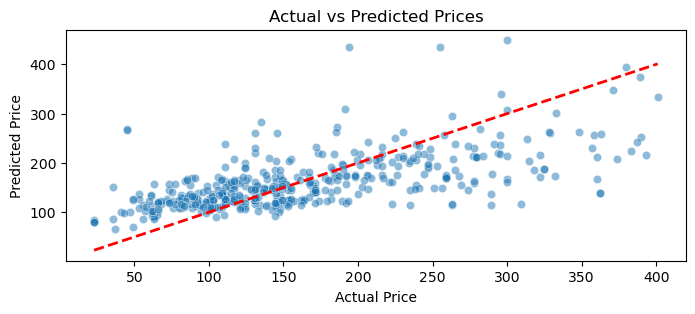

In [5708]:
# Visualizations
plt.figure(figsize=(8, 3))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()


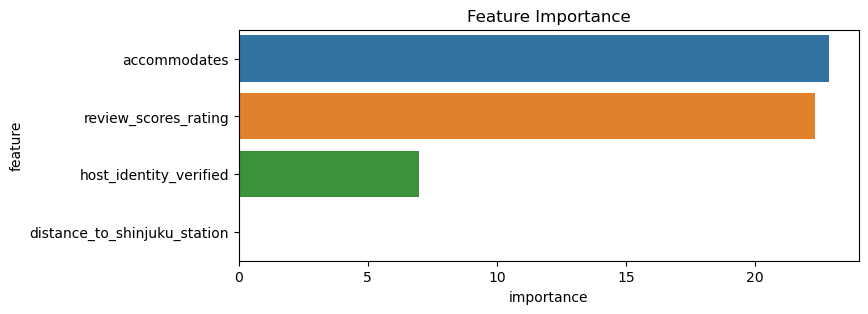

In [5709]:
# Feature Importance
importance = pd.DataFrame({'feature': X.columns, 'importance': abs(model.coef_)})
importance = importance.sort_values('importance', ascending=False)
plt.figure(figsize=(8, 3))
sns.barplot(x='importance', y='feature', data=importance)
plt.title("Feature Importance")
plt.show()

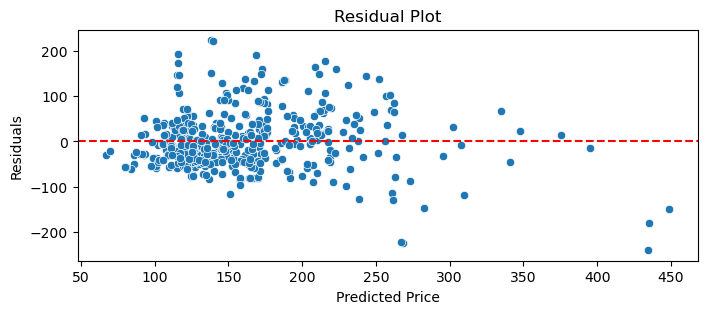

In [5710]:
# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 3))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

Overall scores for multiple regression are higher than those for individual linear regressions, suggesting that travelers or visitors prioritize a combination of factors. These factors may include competitive pricing, location, features such as accommodation capacity, and host reputation. Furthermore, relative impact of distance improved as we limited the dataset to the ward where Shinjuku Station is located, resulting in R2 score of 43%, the highest so far from all the tests.

In [5711]:
df_listings_visualized['price_usd'].describe().round(2)

count    12197.00
mean       146.10
std         85.13
min         10.00
25%         83.00
50%        127.00
75%        191.00
max        410.00
Name: price_usd, dtype: float64

In [5712]:
df_listings_visualized['ward'].value_counts(dropna = False)

ward
Shinjuku Ku      2302
Taito Ku         1654
Sumida Ku        1541
Toshima Ku       1159
Shibuya Ku        784
Ota Ku            488
Minato Ku         473
Setagaya Ku       398
Nakano Ku         362
Kita Ku           358
Katsushika Ku     321
Chuo Ku           272
Suginami Ku       250
Koto Ku           249
Arakawa Ku        247
Bunkyo Ku         245
Itabashi Ku       242
Edogawa Ku        241
Shinagawa Ku      172
Chiyoda Ku        154
Adachi Ku         139
Nerima Ku          75
Meguro Ku          71
Name: count, dtype: int64

In [5713]:
df_listings_visualized.shape

(12197, 80)

In [5714]:
df_listings_visualized.head()

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,ward,latitude,longitude,room_type,...,distance_to_Tokyo Water Bus,distance_to_Kyu Shiba Rikyu,distance_to_Tokyo Midtown,distance_to_Roppongi,distance_to_Akasaka Sacas,distance_to_Shiodome,distance_to_Shinagawa,distance_to_Toyosu,distance_to_shinjuku_station,host_accommodates
0,197677,964081,within a day,100.0,1,1,Sumida Ku,35.717070,139.826080,Entire home/apt,...,8.922210,10.321072,12.116221,12.105863,10.979769,9.378044,13.795318,7.023003,11146.106535,2
1,776070,801494,within an hour,100.0,1,1,Kita Ku,35.738440,139.769170,Private room,...,9.159151,9.083114,9.215182,9.386202,7.914593,8.203570,12.647514,10.553556,7400.421869,1
2,905944,4847803,within an hour,97.0,1,1,Shibuya Ku,35.678780,139.678470,Entire home/apt,...,10.893508,8.750573,5.944202,6.179871,6.487798,9.133952,8.719969,15.344277,3144.057540,6
4,3838856,4626879,within an hour,100.0,1,1,Shibuya Ku,35.682450,139.690090,Entire home/apt,...,9.755051,7.646378,4.850616,5.116797,5.246839,7.950142,8.065074,14.155633,2098.007560,7
5,1196177,5686404,within an hour,100.0,0,1,Adachi Ku,35.744731,139.797384,Private room,...,10.187512,10.753512,11.568009,11.676575,10.270366,9.785463,14.438390,10.155447,9882.507453,4


In [5715]:
df_listings_visualized['host_identity_verified'].value_counts(dropna = False)

host_identity_verified
1    11911
0      286
Name: count, dtype: int64

### 5. Exporting Data Frame in Pkl

In [5716]:
# Export df_listings_explored as “listings_visualized.pkl” under “Prepared Data” folder.
df_listings_visualized.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'listings_supervised_ml.pkl'))

## 6 Export Data frame as csv

In [5717]:
# Export df_listings_explored as “listings_visualized.pkl” under “Prepared Data” folder.
df_listings_visualized.to_csv(os.path.join(path, '02 Data','Prepared Data', 'listings_supervised_ml.csv'))